# IMDb Sentiment Classification — Logistic Regression vs Decision Tree vs Random Forest


## 1) Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2) Data Loading

In [3]:
DATA_PATH = "imdb_acl_cleaned.csv" 

df = pd.read_csv(DATA_PATH)

# Basic validation
expected_cols = {'cleaned_review', 'sentiment'}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Dataset is missing required columns: {missing}")

before = len(df)
df = df.dropna(subset=['cleaned_review', 'sentiment']).copy()
after = len(df)

print(f'Loaded {after} rows (dropped {before - after} with missing values).')
print("\nsentiment distribution:")
print(df['sentiment'].value_counts())

df.head()

Loaded 50000 rows (dropped 0 with missing values).

sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


,review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high cartoon comedy ran time program ...,positive
1,Homelessness (or Houselessness as George Carli...,homelessness houselessness george carlin state...,positive
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant acting lesley ann warren best dramat...,positive
3,This is easily the most underrated film inn th...,easily underrated film inn brook cannon sure f...,positive
4,This is not the typical Mel Brooks film. It wa...,typical mel brook film much less slapstick mov...,positive


## 3) Train/Test Split (80/20, stratified)

In [4]:
X_text = df['cleaned_review'].astype(str)
y = df['sentiment'].astype(str)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train size: {len(X_train_text)}, Test size: {len(X_test_text)}")

Train size: 40000, Test size: 10000


## 4) TF‑IDF Vectorization (fit on train, transform train & test)

In [5]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

print(f"TF-IDF matrix shapes -> Train: {X_train.shape}, Test: {X_test.shape}")

TF-IDF matrix shapes -> Train: (40000, 81344), Test: (10000, 81344)


## 5) Model Training

In [6]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=None),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
}

fitted = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    fitted[name] = model
print("Done!")

Training LogisticRegression...
Training DecisionTree...
Training RandomForest...
Done!


## 6) Evaluation — Accuracy, Precision, Recall, F1 & Reports

In [8]:
def evaluate_model(name, model, X_te, y_te):
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_te, preds, average='weighted', zero_division=0)
    report = classification_report(y_te, preds, digits=3, zero_division=0)
    cm = confusion_matrix(y_te, preds, labels=sorted(y_te.unique()))
    return {
        "name": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "report": report,
        "confusion_matrix": cm,
        "sentiment": sorted(y_te.unique())
    }

results = []
for name, model in fitted.items():
    res = evaluate_model(name, model, X_test, y_test)
    results.append(res)
    print(f"\n=== {name} ===")
    print(res['report'])
    print("Confusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(res['confusion_matrix'], index=res['sentiment'], columns=res['sentiment']))

# Comparison table
metrics_table = pd.DataFrame([
    {"Model": r["name"], "Accuracy": r["accuracy"], "Precision(w)": r["precision"], "Recall(w)": r["recall"], "F1(w)": r["f1"]}
    for r in results
]).sort_values(by="F1(w)", ascending=False).reset_index(drop=True)

metrics_table


=== LogisticRegression ===
              precision    recall  f1-score   support

    negative      0.906     0.879     0.892      5000
    positive      0.883     0.909     0.896      5000

    accuracy                          0.894     10000
   macro avg      0.894     0.894     0.894     10000
weighted avg      0.894     0.894     0.894     10000

Confusion Matrix (rows=true, cols=pred):
          negative  positive
negative      4395       605
positive       454      4546

=== DecisionTree ===
              precision    recall  f1-score   support

    negative      0.719     0.714     0.716      5000
    positive      0.716     0.721     0.718      5000

    accuracy                          0.717     10000
   macro avg      0.717     0.717     0.717     10000
weighted avg      0.717     0.717     0.717     10000

Confusion Matrix (rows=true, cols=pred):
          negative  positive
negative      3568      1432
positive      1397      3603

=== RandomForest ===
              prec

,Model,Accuracy,Precision(w),Recall(w),F1(w)
0,LogisticRegression,0.8941,0.894460,0.8941,0.894076
1,RandomForest,0.8570,0.857023,0.8570,0.856998
2,DecisionTree,0.7171,0.717111,0.7171,0.717097


###  F1-score Comparison Chart

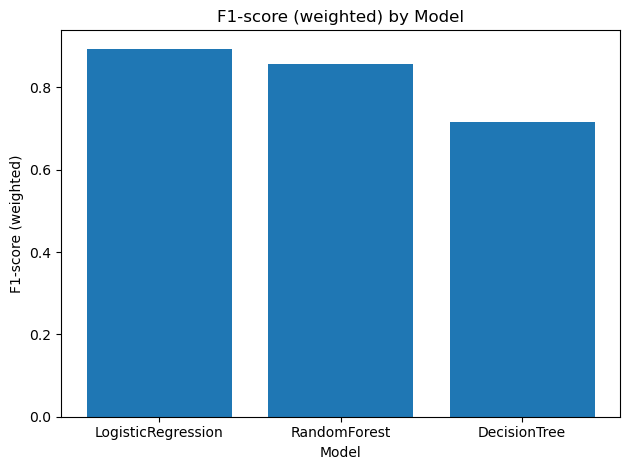

In [9]:
plt.figure()
plt.bar(metrics_table['Model'], metrics_table['F1(w)'])
plt.title('F1-score (weighted) by Model')
plt.xlabel('Model')
plt.ylabel('F1-score (weighted)')
plt.tight_layout()
plt.show()

## 7) Example Predictions

In [10]:
N = 10  
sample_idx = np.random.choice(len(X_test_text), size=min(N, len(X_test_text)), replace=False)
examples = pd.DataFrame({
    "cleaned_review": X_test_text.iloc[sample_idx].values,
    "true_label": y_test.iloc[sample_idx].values
}).reset_index(drop=True)

for name, model in fitted.items():
    preds = model.predict(tfidf.transform(examples['cleaned_review']))
    examples[name + "_pred"] = preds

examples

,cleaned_review,true_label,LogisticRegression_pred,DecisionTree_pred,RandomForest_pred
0,saw movie video couple friend part teen comedy...,negative,negative,negative,negative
1,love review movie mirror attitude sort guy min...,positive,negative,positive,negative
2,picky movie seen much crap could watch anythin...,negative,negative,negative,negative
3,anyone aware original british lion movie wicke...,negative,negative,positive,negative
4,casting bone pick david jannsen playing father...,negative,negative,negative,negative
5,movie movie felt like one school special lower...,negative,negative,positive,negative
6,checked imdb renting dvd netflix couple hour l...,negative,negative,positive,negative
7,first time saw film kid ten year old released ...,positive,positive,positive,positive
8,let see trying practice finding positive every...,negative,negative,positive,negative
9,although super mario like rest game series sti...,positive,positive,positive,positive


## 8) Insights — Which model works best and why?
- **Logistic Regression** often performs best on TF‑IDF text features because it's a linear model that handles **high-dimensional sparse vectors** well and tends to generalize nicely.
- **Decision Trees** can overfit sparse high‑dimensional text very easily, typically leading to lower generalization performance.
- **Random Forest** reduces overfitting vs. a single tree and can perform competitively, but with TF‑IDF text features, linear models frequently edge it out. Forests are also more computationally expensive.

**Interpretability vs Performance:**
- **Decision Tree** is the most interpretable (you can visualize rules), but may underperform.
- **Logistic Regression** is fairly interpretable (inspect top coefficients per class) and tends to be strongest on sparse TF‑IDF features.
- **Random Forest** is less interpretable than a single tree but sometimes improves robustness at the cost of transparency.
